<a href="https://colab.research.google.com/github/vishwashrisairam/AI-Workshop/blob/master/SkinLesionSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Lesion Segmentation


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mike-holcomb/RWAIPDay3/blob/master/SkinLesionSegmentation.ipynb)

![Skin Lesion Cover](https://raw.githubusercontent.com/mike-holcomb/curaeaidlhw-codelab1-skin-cancer-mnist/master/imgs/skin-mnist-cover.png) 

Data from https://challenge.kitware.com/#challenge/560d7856cad3a57cfde481ba

Day 3 AM Code Lab for:
[UTD AIS: Real World A.I. Workshop Spring 2020](https://aisutd.org/real-world-ai-2020/index.html)

## Problem

From the [2019 ISIC Challenge](https://challenge2019.isic-archive.com/):
> Skin cancer is the most common cancer globally, with melanoma being the most deadly form. Dermoscopy is a skin imaging modality that has demonstrated improvement for diagnosis of skin cancer compared to unaided visual inspection. However, clinicians should receive adequate training for those improvements to be realized. In order to make expertise more widely available, the International Skin Imaging Collaboration (ISIC) has developed the ISIC Archive, an international repository of dermoscopic images, for both the purposes of clinical training, and for supporting technical research toward automated algorithmic analysis by hosting the ISIC Challenges.

Today, we will focus on Task 1 from the 2016 ISIC Challenge: Lesion segmentation.  Specifically, we are given 900 dermatoscopic specimens with segmentation masks identifying which portion of the image contains the lesion under testing.

### Semantic Segmentation
Semantic segmentation can be thought of like an image classification task except we must predict a class for each pixel, rather than the image overall.  In our problem today we are only predicting two classes ("lesion" vs "background"), but these types of models can be used to segment pixels into various regions by formulating a multi-class semantic segmentation problem.

Semantic segmentation is distinct from instance segmentation in that our models do not specify whether two neighboring pixels of the same class belong to the same object.

## Data

### Downloading the data

A version of the data that has been uniformly resized and organized is made available via a Google Drive link.

In [42]:
!pip install gdown

In [43]:
import gdown 
url = 'https://drive.google.com/uc?id=1eeosaogUOHNSoU1Pe3j3TLG9MrFKHzur'
output = 'data.tar.gz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1eeosaogUOHNSoU1Pe3j3TLG9MrFKHzur
To: /content/data.tar.gz
22.8MB [00:00, 190MB/s]


'data.tar.gz'

In [19]:
!ls

data.tar.gz  imgs  masks  sample_data


In [0]:
!rm -rf masks
!rm -rf imgs
!tar xzf data.tar.gz

### Inspecting the data

In [0]:
import PIL.Image as Image
import PIL.ImageOps as ImageOps
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

We are given 900 color images (`.jpg` files) of skin lesions, all of which have been resized to 512 x 512.

In [0]:
IDX = 25

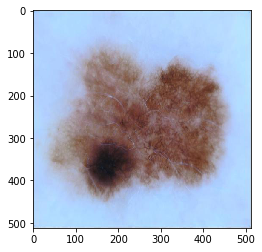

In [47]:
img = Image.open(f"imgs/{IDX}.jpg")
plt.imshow(img)

In addition, we are also provided masks that mark the corresponding pixels in the input image with a flag indicating whether the pixel is a background or clear pixel (0) or a pixel belonging to a lesion (255) in `.PNG` files.

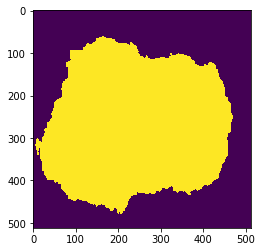

In [48]:
mask = Image.open(f"masks/{IDX}.png")
plt.imshow(mask)

We can use the mask to 'mask' out the background and only isolate the lesion.

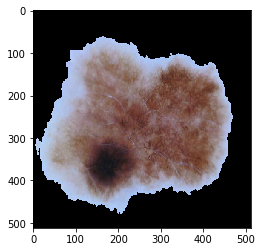

In [49]:
plt.imshow(np.expand_dims(mask,2)//255 * np.array(img))

Also, we can use these masks to automatically compute geometric features of importance to dermatologists such as symmetry, border regulatrity, diameter, color distribution as well as tracking changes over time.  For more about the ABCDE's of melanoma, click here: https://www.preventcancer.org/programs/save-your-skin/

### Loading the images and masks

In [0]:
import glob

img_paths = sorted(glob.glob('imgs/*.jpg'))
mask_paths = sorted(glob.glob('masks/*.png'))

In [0]:
imgs = np.zeros((len(img_paths),512,512,3))
for i, img_path in enumerate(img_paths):
  imgs[i] = np.array(Image.open(img_path),dtype='float32')/255

In [0]:
masks = np.zeros((len(img_paths),512,512,1))
for i, mask_path in enumerate(mask_paths):
  png_mask = Image.open(mask_path).convert("1")
  masks[i,:,:,0] = np.array(png_mask, dtype=np.int)

### Construct Splits

To help train and evaluate our model, we will now construct three partitions of the data:


*   **Training set (80%):** We will use these samples to train the parameters of the neural network.
*   **Evaluation set or "dev set" (10%)**: We will use these held-out samples to compare the effectiveness various hyperparameter settings during training.
*   **Test set (10%)**: Finally, we will use a second held-out set of samples to evaluate the model's potential to generalize to unseen data.

It is considered a best practice to use a separate dev set for hyperparameter tuning and a test set for final evaluation.  If you include the final test set in your hyperparameter tuning loop, your held-out data set becomes a part of your training and weakens its effectiveness as an indicator for the power of your model in generalizing to unseen samples.  As such, be careful not to evaluate your model on the test set too frequently though the temptation exists!


In [54]:
import random
seed = 1
batch_size = 8
random.seed(1)

splits = ["train","eval","test"]
data = { s: {} for s in splits}

n = len(imgs)
k1 = int(0.8 * n)
k2 = int(0.9 * n)
all_idxs = list(range(n))
random.shuffle(all_idxs)

data['train']['idxs'] = all_idxs[:k1]
data['eval']['idxs'] = all_idxs[k1:k2]
data['test']['idxs'] = all_idxs[k2:]

print("Split sizes:")
for s in splits:
  data[s]['size'] = len(data[s]['idxs'])
  print(f"\t{s.upper()}: {data[s]['size']}")

Split sizes:
	TRAIN: 720
	EVAL: 90
	TEST: 90


### Construct data loaders and augmentation

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
from  tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
eval_augmentations = {}

# Potential other augmentations here
train_augmentations = {}
train_augmentations.update(eval_augmentations)

def combine_generator(gen1, gen2):
  while True:
      yield(gen1.next(), gen2.next()) 

for s in splits:
  augmentations = train_augmentations if s == 'train' else eval_augmentations
  img_datagen = ImageDataGenerator(**augmentations)
  mask_datagen = ImageDataGenerator(**augmentations)

  idxs = data[s]['idxs']
  img_generator = img_datagen.flow(imgs[idxs], seed=seed, batch_size=batch_size)
  mask_generator = mask_datagen.flow(masks[idxs], seed=seed, batch_size=batch_size)
 
  data[s]['generator'] = combine_generator(img_generator, mask_generator)

Now let's inspect what the images look like after augmentation

In [57]:
for x, y in data['train']['generator']: 
  print(x.shape)
  print(y.shape)
  break

(8, 512, 512, 3)
(8, 512, 512, 1)


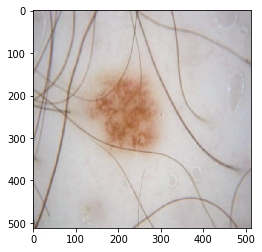

In [58]:
plt.imshow(x[0])

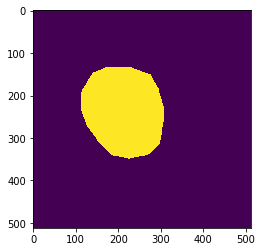

In [59]:
plt.imshow(y[0,:,:,0])

## Model

### U-Net

On the simple, yet very effective semantic segmentation model architectures often used in the biological sciences is U-Net. As its name implies, the U-shape network:


1.   Begins with an encoder branch which appears very similar to ordinary CNN's used in image classification, moving from wide and tall fields of weaker features to smaller fields of stronger features;
2.   Ends with a decoder branch which uses a combination of convolution operations and upsampling to generate wider feature maps that still benefit from the broader perceptive field of the terminal layers of the encoder; and
3. Residual connections between stages of the encoder and decoder to help the gradients flow back to the earliest portions of the network.

For the original paper describing the architecture see:[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)


![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [0]:
# Adapted from https://github.com/zhixuhao/unet
# Note: there are a number of differences to the original paper annotated below
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def UNet(input_dim=512, base_channels=64):
    inputs = Input((input_dim, input_dim,3))

    # Encoder branch ("contracting path" in the paper)
    # As a side note, the original paper uses "valid" padding
    conv1 = Conv2D(base_channels, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(base_channels, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(base_channels*(2**1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(base_channels*(2**1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(base_channels*(2**2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(base_channels*(2**2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(base_channels*(2**3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(base_channels*(2**3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom of the "U"
    conv5 = Conv2D(base_channels*(2**4), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(base_channels*(2**4), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder branch
    up6 = UpSampling2D(size = (2,2),interpolation='bilinear')(drop5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up6)
    
    # Note: as a difference to the original paper's use of valid padding,
    #       the connection to the encoder is cropped to match the decoder's 
    #       spatial dimensions - this approach potentially limits the gradient flow back into the encoder
    merge6 = concatenate([drop4,up6], axis = 3) # Connection to encoder
    conv6 = Conv2D(base_channels*(2**3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(base_channels*(2**3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = UpSampling2D(size = (2,2),interpolation='bilinear')(conv6)
    up7 = Conv2D(base_channels*(2**2), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
    merge7 = concatenate([conv3,up7], axis = 3) # Connection to encoder
    conv7 = Conv2D(base_channels*(2**2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(base_channels*(2**2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = UpSampling2D(size = (2,2),interpolation='bilinear')(conv7)
    up8 = Conv2D(base_channels*(2**1), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
    merge8 = concatenate([conv2,up8], axis = 3) # Connection to encoder
    conv8 = Conv2D(base_channels*(2**1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(base_channels*(2**1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = UpSampling2D(size = (2,2),interpolation='bilinear')(conv8)
    up9 = Conv2D(base_channels, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(base_channels, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(base_channels, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    # Final layer is pixel-wise conolution into sigmoid - probability that pixel participates in a lesion
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    return model

### Loss Function

With semantic segmentation, it would be possible to use binary cross-entropy as our loss (in this instance with two categories), but a more successful loss function would be soft dice loss, which is the complement to the Dice coefficient. 

The Dice coefficient can be thought of as a the pixel-wise F1 score.

$$Dice = \frac{2 |y_{true} \cap y_{pred}|}{|y_{true}|+|y_{pred}|}$$

Dice coefficient is calculated as the twice the size of the intersection of the two sets divided by sum of the sizes of the two sets.  In minimizing the the complement, our loss optimization routine maximizes the overlap between our predicted foreground and the true foreground as complete as possible.

As an aside, a smoothing factor in the implementation below is introduced to help with numerical stability.

One of the primary benefits of using this function is that it helps to mitigate the inherent class imbalance between foreground and background pixels often seen in  real world datasets.

In [0]:
# Adapted from https://github.com/karolzak/keras-unet
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)

In [0]:
 model = UNet(512,32)
 model.compile(optimizer = Adam(lr = 1e-4), loss = dice_loss, metrics = ['accuracy'])

In [77]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 512, 512, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_69[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 256, 256, 32) 0           conv2d_70[0][0]                  
____________________________________________________________________________________________

## Training

In [0]:
checkpoint = ModelCheckpoint('tmp.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [95]:
history = model.fit_generator(data['train']['generator'],
                    steps_per_epoch=data['train']['size']//batch_size,
                    validation_data=data['eval']['generator'],
                    validation_steps=data['eval']['size']//batch_size,
                    callbacks=[checkpoint],
                    epochs=30)

Epoch 1/30
11/90 [==>...........................] - ETA: 15s - loss: 0.5884 - acc: 0.3006
Epoch 00001: val_loss did not improve from 0.11877
90/90 [==============================] - 44s 493ms/step - loss: 0.5560 - acc: 0.3829 - val_loss: 0.5884 - val_acc: 0.3006
Epoch 2/30
11/90 [==>...........................] - ETA: 11s - loss: 0.6085 - acc: 0.2923
Epoch 00002: val_loss did not improve from 0.11877
90/90 [==============================] - 42s 464ms/step - loss: 0.5572 - acc: 0.3837 - val_loss: 0.6085 - val_acc: 0.2923
Epoch 3/30
11/90 [==>...........................] - ETA: 11s - loss: 0.5768 - acc: 0.4165
Epoch 00003: val_loss did not improve from 0.11877
90/90 [==============================] - 42s 464ms/step - loss: 0.5349 - acc: 0.3949 - val_loss: 0.5768 - val_acc: 0.4165
Epoch 4/30
11/90 [==>...........................] - ETA: 11s - loss: 0.3168 - acc: 0.8604
Epoch 00004: val_loss did not improve from 0.11877
90/90 [==============================] - 42s 464ms/step - loss: 0.4063

## Evaluation

### Quantitative

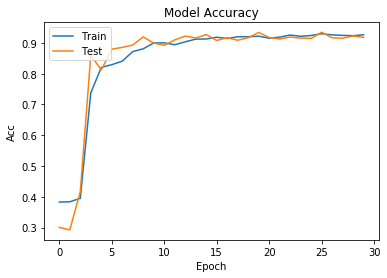

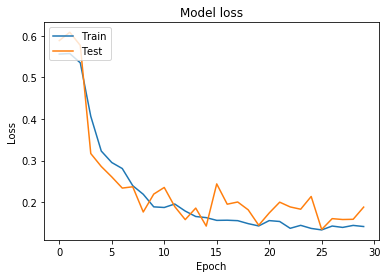

In [96]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Don't run this too often or you are a bad person...

In [0]:
model.load_weights('tmp.hdf5')

In [98]:
dice_loss, acc = model.evaluate_generator(data['test']['generator'],
                         steps=data['test']['size']//batch_size)
print(f"Dice Coef: {1-dice_loss} Pixel-wise Accuracy: {acc}")

Dice Coef: 0.9000642570582303 Pixel-wise Accuracy: 0.948719322681427


### Qualitative

In [0]:
pred_mask = model.predict(x[0:1])

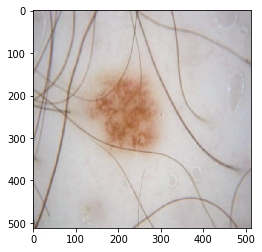

In [100]:
plt.imshow(x[0])

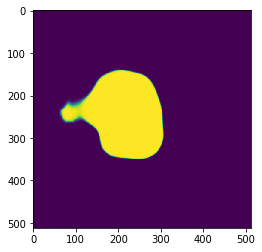

In [101]:
plt.imshow(pred_mask[0,:,:,0])

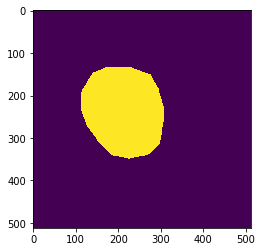

In [102]:
plt.imshow(y[0,:,:,0])

In [0]:
delta = y[0,:,:,0]-(pred_mask[0,:,:,0]>0.5)

In [0]:
in_true = np.expand_dims(delta > 0,2)
in_pred = np.expand_dims(delta < 0,2)
delta_color = in_true*[1.,1.,0.]+ in_pred*[1.,0.,1.]

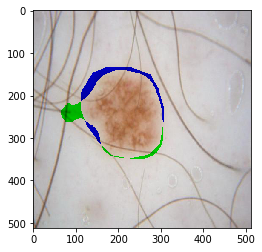

In [105]:
plt.imshow((1-delta_color) * x[0])